<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/SARIMA_1YEAR_TO_1MONTH_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools


# 돌리기전에, https://colab.research.google.com/drive/1oBXX3k3OOjdivwlDhpLmAqfq5B5dzFR1#scrollTo=AbTlhWommsXE 에 있는 코드도 참고 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보자    ( https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=nzZ6wGntXBrP 참고)
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

# 그래프에서 한글깨짐방지를 위한 한글폰트(나눔폰트) 설치 및 설정과정

!apt-get update -qq                    # 나눔폰트(한글) 설치
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

Python 3.6.9
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0
Selecting previously unselected package fonts-nanum.
(Reading database ... 144676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumGo

In [3]:
!pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

     |████████████████████████████████| 40kB 2.0MB/s 
     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 235kB 11.2MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 주가 크롤링

from pykrx import stock
df = stock.get_market_ohlcv_by_date("20190701", "20200831", "122870") # DataFrame, (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-07-01,29100,29400,28400,28500,233660
2019-07-02,28250,29800,28200,29000,384554
2019-07-03,29300,29300,28350,28550,264976
2019-07-04,28550,29150,28500,28850,131863
2019-07-05,29000,29200,28600,29050,126249
...,...,...,...,...,...
2020-08-25,47200,49350,47000,48700,397671
2020-08-26,48750,50800,48100,50400,586564
2020-08-27,49950,51400,49450,50900,528784


In [6]:
# train,test 데이터 나누기

train = df[:'2020-08-01']                   # 2019-08-01 ~ 2020-07-31 (약 1년) 
test=df['2020-08-01':]                      # 2020-08-01 ~ 2020-08-31 (약 1개월)  


# column들 중, 종가만 고려한다
train.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)
test.drop(['시가', '고가','저가','거래량'], axis='columns', inplace=True)

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True 

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


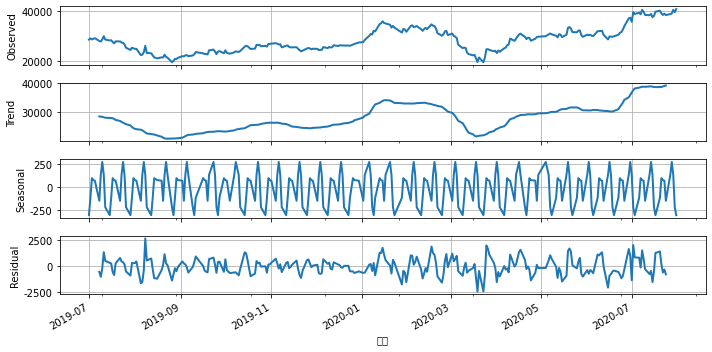

In [8]:
# 시계열분해

# 시계열데이터는 순서를 갖는 데이터, 즉 시간의 흐름에 따라 값이 변하는 데이터
# 시계열에는 경향(trend), 계절성(seasonality), 주기(cycle), 불규칙성(irregular) 성분이 있음.

result = seasonal_decompose(train.dropna(), model='additive',freq=10)   # freq = 10 (2-WEEKS )
result.plot()
plt.show()

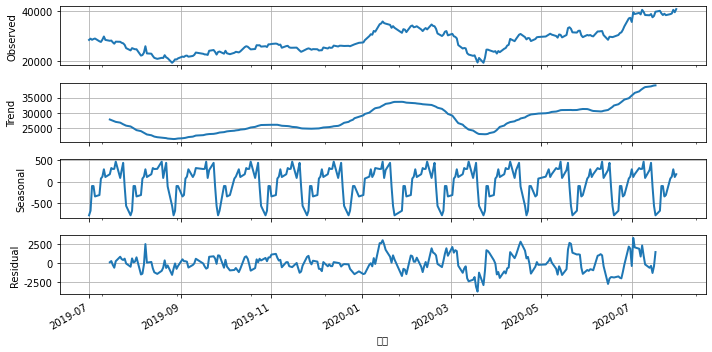

In [9]:
result = seasonal_decompose(train.dropna(), model='additive',freq=20)   # freq=20 (1-MONTH)
result.plot()
plt.show()

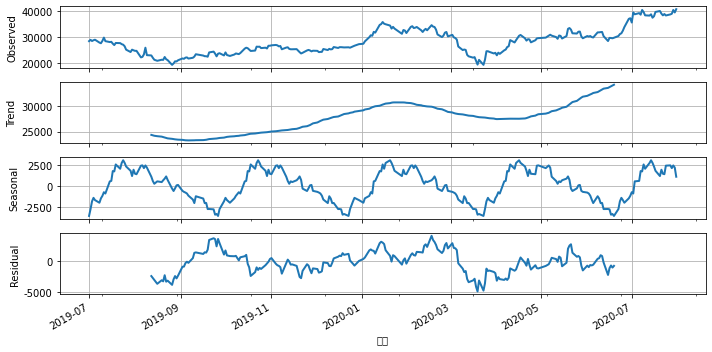

In [10]:
result = seasonal_decompose(train.dropna(), model='additive',freq=60)   # freq=60 (3-MONTH)    # 추세(trend)가 어느정도 보이고, 계절성(seasonal)도 뚜렷한 것을 볼수 있음.
result.plot()
plt.show()

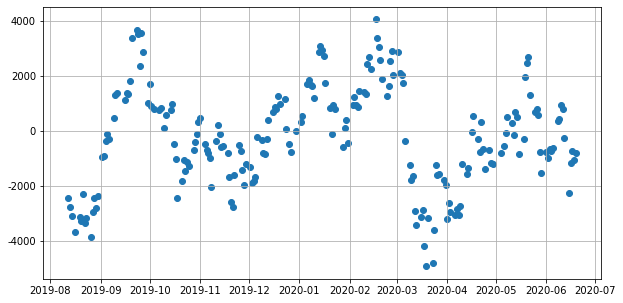

In [11]:
# 잔차분포 확인

residual=result.resid
residual=residual.dropna()

# 잔차 산포도 확인
plt.scatter(x=residual.index,y=residual)

# plt.hist(x=residual,bins=50)

In [12]:
# 정상성 확인함수 

# p-value가 0.05이하여야 정상성을 만족함  
# 그래프는 rollin_mean : 이동평균, rolling_std : 이동표준편차  
# 이동평균, 이동표준편차 : 정상성을 만족한다는 것은, 데이터의 평균과 분산이 일정하다는 의미이다. 
# 이동평균,이동표준편차 그래프를 통해서 평균과 표준편차가 x축과 평행인 선을 그리는지 알수 있기 때문에 그래프를 만들었음 
 
def get_stationarity(timeseries,wind_date):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=wind_date).mean()
    rolling_std = timeseries.rolling(window=wind_date).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['종가'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


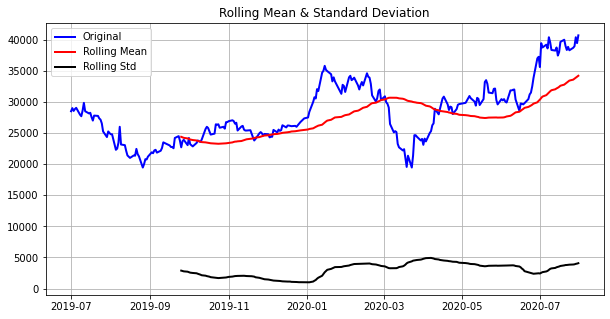

ADF Statistic: -0.6667939345703924
p-value: 0.8551642206624652
Critical Values:
	1%: -3.4548039258751206
	5%: -2.872304928618605
	10%: -2.5725063100137175


In [13]:
get_stationarity(train,60) # p-value : 0.60.. > 0.05 => Non-Stationary

In [14]:
train_diff=train.diff()
train_diff=train_diff.dropna()                # 종가를 1차차분한 값들 -> train_diff 

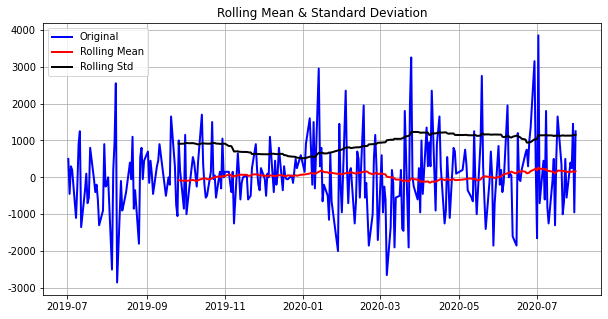

ADF Statistic: -16.774739342204683
p-value: 1.2784087738923505e-29
Critical Values:
	1%: -3.4548957220044336
	5%: -2.8723451788613157
	10%: -2.572527778361272


In [15]:
get_stationarity(train_diff,60) # p-value : 0.00.. < 0.05  / 이동평균선과 이동표준편차가 x축과 평행 => Stationary (p,d,q중, d = 1 / s=60)

<function matplotlib.pyplot.show>

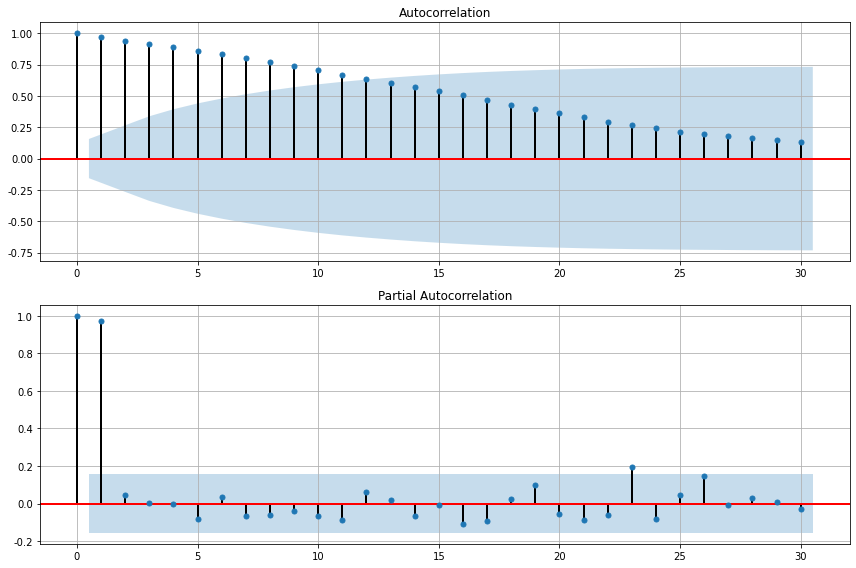

In [16]:
# ACF그래프 (자기상관함수) : 
#자기상관은 시점 t 와 (t - n) 간의 상관 관계를 의미하며 한동안(일정 기간) 증가하거나 감소하는 경우 양의 자기상관이 존재한다고 하고 시점마다 증감이 반복되는 경우 이를 음의 자기상관이라 한다

# PACF그래프 (부분자기상관함수) : 
# 부분자기상관은 시점 (t-1) ~ (t-n+1)의 영향을 배제한, 시점 t와 (t - n)과의 상관관계를 의미한다.   

# ACF, PACF그래프의 x축은 lag,지연값,시점 (t-n)에서 n의 값이다.

# train 원데이터의 ACF, PACF그래프 그리기
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=30, ax=ax1, alpha=0.01)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=30,ax=ax2,alpha=0.01)
plt.tight_layout()
plt.show


# => Random Walk (Non-Stationary)의 특징을 보임 
# Acf그래프에서는 천천히 감소, Pacf에서는 급격하게 감소 (lag=1에서 절단점 발생) => 차분하지 않은 데이터는 AR모형의 특성을 띄는 경향이 있는 것으로 보임 

<function matplotlib.pyplot.show>

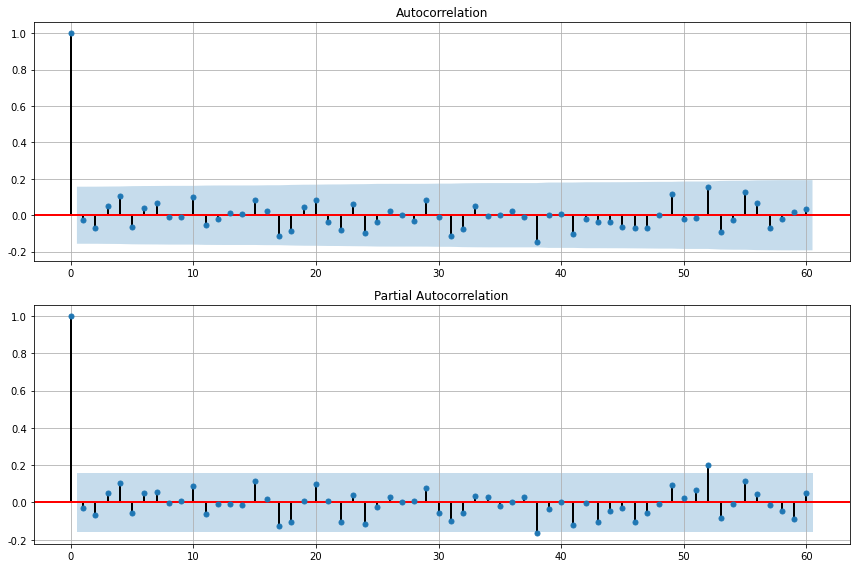

In [17]:
# train데이터를 1차차분한 값의 ACF,PACF그래프 그리기
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_diff, lags=60, ax=ax1, alpha=0.01)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_diff,lags=60,ax=ax2,alpha=0.01)
plt.tight_layout()
plt.show

# => White noise(Stationary)데이터의 acf,pacf그래프 양상을 보임 , ARIMA(p,d,q)에서 p=0, q=0 

# 따라서, 1차차분한 값의 p=0,q=0이라고 판단됨 => (p,d,q) = (0,1,0)

In [18]:
# 그래프등을 통해 판단된 값으로 ARIMA모델실행, Fitting

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(0,1,0))
model_fit = model.fit(trend='c',full_output=True, disp=1) 
print(model_fit.summary()) 

#  P > |z| 값이 일반적으로 학습의 적정성을 위해 확인되는 t-test값 , 그런데 0.313으로 p-value 0.05수준에서 보면 유효하지 않음 

                             ARIMA Model Results                              
Dep. Variable:                   D.종가   No. Observations:                  270
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2242.774
Method:                           css   S.D. of innovations            980.077
Date:                Thu, 24 Sep 2020   AIC                           4489.548
Time:                        07:44:27   BIC                           4496.744
Sample:                             1   HQIC                          4492.438
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.1852     59.646      0.758      0.449     -71.718     162.088


In [19]:
# Auto_Arima모델 

In [20]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 3.5MB/s 
     |████████████████████████████████| 2.1MB 20.1MB/s 
     |████████████████████████████████| 8.7MB 35.9MB/s 
     |████████████████████████████████| 808kB 29.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0


In [21]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=60,
                           seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)


# AIC값이 최소값이 나오는 파라미터를 선정한다.
# AIC는 Akaike Information Criterion이다. AIC는 얼마나 모델이 데이터를 잘 피팅하는지를 측정함. 
# AIC(Akaike Information Criterion) value
# The AIC measures how well a model fits the data while taking into account the overall complexity of the model.
# A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit.


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[60]             : AIC=inf, Time=110.04 sec
 ARIMA(0,1,0)(0,1,0)[60]             : AIC=3619.177, Time=2.12 sec
 ARIMA(1,1,0)(1,1,0)[60]             : AIC=3608.879, Time=10.66 sec
 ARIMA(0,1,1)(0,1,1)[60]             : AIC=3601.926, Time=28.88 sec
 ARIMA(0,1,1)(0,1,0)[60]             : AIC=3621.137, Time=1.37 sec
 ARIMA(0,1,1)(1,1,1)[60]             : AIC=inf, Time=75.52 sec
 ARIMA(0,1,1)(0,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,1)(1,1,0)[60]             : AIC=3607.758, Time=26.69 sec
 ARIMA(0,1,1)(1,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(0,1,1)[60]             : AIC=3600.534, Time=37.14 sec
 ARIMA(0,1,0)(1,1,1)[60]             : AIC=inf, Time=38.99 sec
 ARIMA(0,1,0)(0,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(1,1,0)[60]             : AIC=3606.169, Time=18.70 sec
 ARIMA(0,1,0)(1,1,2)[60]             : AIC=inf, Time=nan sec
 ARIMA(1,1,0)(0,1,1)[60]             : AIC=3601.9

In [22]:
result_seasonal=stepwise_model.fit(train)
print(result_seasonal.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  271
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 60)   Log Likelihood               -1798.267
Date:                            Thu, 24 Sep 2020   AIC                           3600.534
Time:                                    07:52:54   BIC                           3607.228
Sample:                                         0   HQIC                          3603.240
                                            - 271                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L60      -0.3353      0.029    -11.366      0.000      -0.393      -0.277
sigma2      1.538e+06    1.4e+05   

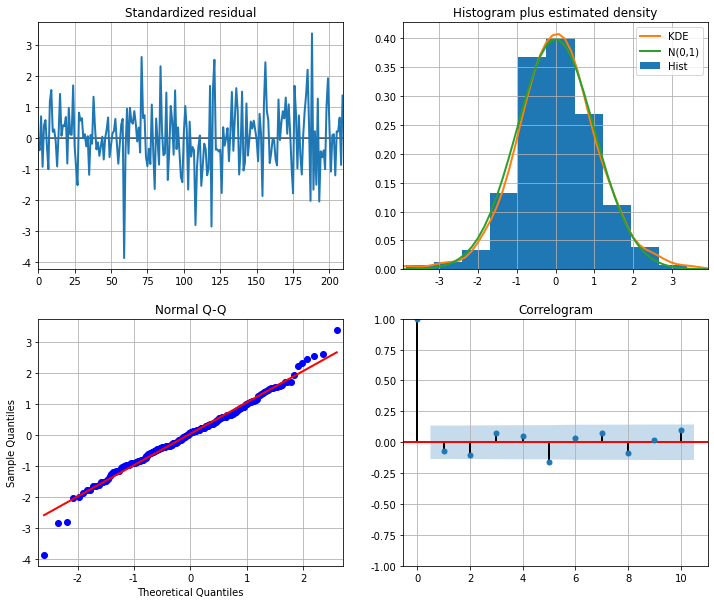

In [23]:
# 잡음(불규칙요인)의 분포 살피기 (표준잔차, 잔차분포, Normal Q-Q (QQ-Plot), 상관성)

# https://data.library.virginia.edu/diagnostic-plots/ 참고

# 표준화 잔차 (Standardized residual) : 추정 회귀식으로부터 관측치가 얼마나 떨어져 있는지, 절댓값 3이상이면 이상값이 확실, 연구자에 따라 2~3사이의 값을 이상값일 가능성이 달라짐.
# 잔차분포 (Histogram plus estimated density) :  KDE - 커널밀도추정 (정규분포를 스무딩한 것) ( https://darkpgmr.tistory.com/147 참고 ) - 잔차분포(N(0,1))가 KDE와 비슷하다 즉, 잔차가 정규분포 다시말해 회귀모델의 가정중 하나인 잔차가 독립이라는 것을 따른다는 이야기  
# QQ-plot (Normal-QQ) : 수집 데이터를 표준정규분포의 분위수와 비교하여 그리는 그래프 -> 데이터의 정규성 가정에 대한 검토를 가능하게 해줌 -> 집단이 정규성을 따른다면, 점들이 직선의 형태로 그려짐.
# 상관성 (Correlogram): ACF 그래프  

result_seasonal.plot_diagnostics(figsize=(12,10))          
plt.show()                                                

In [24]:
print(train.shape) # [248,1] 
print(test.shape) # [20,1] 약 한달

(271, 1)
(20, 1)


In [25]:
pred_seasonal = result_seasonal.predict(n_periods=20) # test개수만큼 예측
print(pred_seasonal)

pred_seasonal = pd.DataFrame(pred_seasonal,index = test.index,columns=['Prediction'])

[40170.69590698 39827.49775456 40747.33786745 40536.34867544
 40309.2416135  40804.31165334 42532.95728565 42460.97971421
 41615.81292421 40545.9351249  40640.61883003 41346.22980524
 41421.71667185 39851.22359656 39511.62227515 39839.66833687
 39661.34979751 39647.32527329 38881.87544135 38463.26988079]


<function matplotlib.pyplot.show>

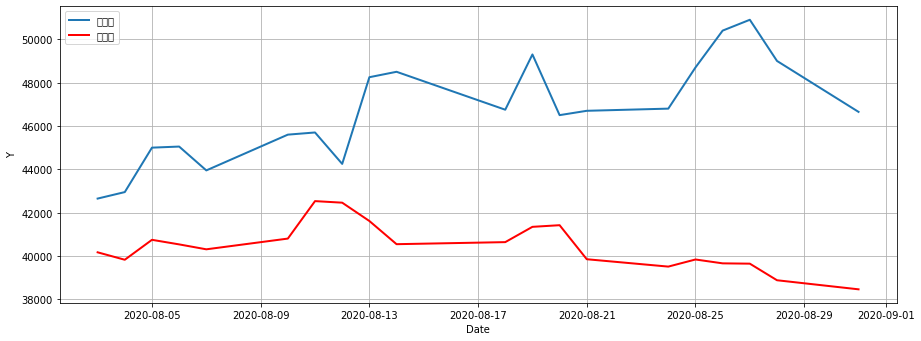

In [26]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(test,label='실제값' )
ax1.plot(pred_seasonal,color='red',label='예측값')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc=2)
plt.show

In [27]:
# Compute the Mean of Absolute Percentage Errors

mape = ((abs( pred_seasonal['Prediction'] - test['종가'] ) / test['종가'])*100).mean()
print('The MAPE of our forecasts is {}%'.format( round(mape, 2) ) ) 

The MAPE of our forecasts is 13.13%
